In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set basic plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 8]
def plot_filter_analysis(system, title, f_range=(20, 20000)):
    """Plot the Bode diagram (magnitude + phase) and time-domain responses for a filter"""
    # Frequency domain - Bode plot
    w = np.logspace(np.log10(f_range[0]*2*np.pi), np.log10(f_range[1]*2*np.pi), 1000)
    w, mag, phase = signal.bode(system, w)
    
    # Create input and output signals (time domain)
    fs = 44100
    t = np.linspace(0, 0.05, int(0.05*fs))
    
    # Step response
    t_step, step = signal.step(system, T=t)
    
    # Create input signal with multiple frequencies
    input_signal = np.sin(2*np.pi*100*t) + 0.5*np.sin(2*np.pi*1000*t) + 0.25*np.sin(2*np.pi*5000*t)
    t_out, output_signal, _ = signal.lsim(system, input_signal, t)
    
    # Create the plot with 4 subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 14))
    
    # Plot magnitude response
    axs[0].semilogx(w/(2*np.pi), mag)
    axs[0].set_title(f'Magnitude Response: {title}')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Magnitude (dB)')
    axs[0].grid(True, which="both")
    
    # Plot phase response
    axs[1].semilogx(w/(2*np.pi), phase)
    axs[1].set_title(f'Phase Response: {title}')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Phase (degrees)')
    axs[1].grid(True, which="both")
    
    # Plot step response
    axs[2].plot(t_step, step)
    axs[2].set_title(f'Step Response: {title}')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Amplitude')
    axs[2].grid(True)
    
    # Plot input/output signal
    axs[3].plot(t, input_signal, 'r--', label='Input Signal')
    axs[3].plot(t_out, output_signal, 'b-', label='Output Signal')
    axs[3].set_title(f'Response to Complex Input: {title}')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Amplitude')
    axs[3].legend()
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

# 1. RC Low-Pass Filter (1 kHz cutoff)
def analyze_low_pass_filter():
    # Filter parameters
    fc = 1000  # 1 kHz cutoff
    R = 15000  # 15 kΩ
    C = 10e-9  # 10 nF
    
    # Transfer function: H(s) = 1/(RCs + 1)
    num = [1]
    den = [R*C, 1]
    system = signal.TransferFunction(num, den)
    
    plot_filter_analysis(system, "RC Low-Pass Filter (1 kHz cutoff)", f_range=(100, 10000))
    
    print("RC Low-Pass Filter:")
    print(f"Cutoff frequency: {fc} Hz")
    print(f"R = {R/1000} kΩ, C = {C*1e9} nF")
    print(f"Time constant = {R*C*1000} ms")

# 2. Low-Shelf Filter (Bass Boost, +6 dB at 200 Hz)
def analyze_low_shelf_filter():
    # Filter parameters
    fc = 200        # Cutoff frequency (Hz)
    G0 = 2          # Low-frequency gain (+6 dB)
    Ginf = 1        # High-frequency gain (0 dB)
    
    wc = 2 * np.pi * fc

    # Corrected low-shelf transfer function:
    # H(s) = Ginf * (s + wc * sqrt(G0/Ginf)) / (s + wc * sqrt(Ginf/G0))
    sqrt_G_ratio = np.sqrt(G0 / Ginf)
    sqrt_G_inv_ratio = np.sqrt(Ginf / G0)

    num = [Ginf, wc * sqrt_G_ratio]
    den = [1, wc * sqrt_G_inv_ratio]

    system = signal.TransferFunction(num, den)

    # Plot and display info
    plot_filter_analysis(system, "Low-Shelf Filter (200 Hz, +6 dB boost)", f_range=(20, 2000))

    print("Low-Shelf Filter:")
    print(f"Transition frequency: {fc} Hz")
    print(f"Low-frequency gain: +{20*np.log10(G0):.1f} dB")
    print(f"High-frequency gain: +{20*np.log10(Ginf):.1f} dB")


# 4. Envelope Follower (simplified model)
def analyze_envelope_follower():
    # Create a visualization of the envelope follower
    fs = 44100
    duration = 0.3
    t = np.linspace(0, duration, int(fs * duration))
    
    # Create an input signal with varying amplitude
    # Simulate a guitar note with exponential decay
    f_note = 220  # A3 note
    attack_time = 0.01  # 10ms
    decay_time = 0.1    # 100ms
    
    # Create the note envelope
    envelope = np.zeros_like(t)
    for i, time in enumerate(t):
        if time < attack_time:
            envelope[i] = time / attack_time
        else:
            envelope[i] = np.exp(-(time - attack_time) / decay_time)
    
    # Create a signal with harmonics
    signal = envelope * (np.sin(2*np.pi*f_note*t) + 
                         0.5*np.sin(2*np.pi*2*f_note*t) + 
                         0.3*np.sin(2*np.pi*3*f_note*t))
    
    # Full-wave rectification
    rectified = np.abs(signal)
    
    # Use the exact time constants from the document
    ef_attack_time = 0.01  # 10ms attack time (from document)
    ef_decay_time = 0.1    # 100ms decay time (from document)
    
    # Smoothing with different time constants for attack and decay
    smoothed = np.zeros_like(rectified)
    
    # Apply asymmetric smoothing
    for i in range(1, len(t)):
        if rectified[i] > smoothed[i-1]:  # Attack phase
            smoothed[i] = smoothed[i-1] + (rectified[i] - smoothed[i-1]) * (1 - np.exp(-1/(ef_attack_time*fs)))  # 10ms attack
        else:  # Decay phase
            smoothed[i] = smoothed[i-1] + (rectified[i] - smoothed[i-1]) * (1 - np.exp(-1/(ef_decay_time*fs)))   # 100ms decay
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, 'b-', label='Input Signal')
    plt.plot(t, rectified, 'g-', alpha=0.5, label='Rectified Signal')
    plt.plot(t, smoothed, 'r-', linewidth=2, label='Envelope')
    plt.title('Envelope Follower: Input Signal and Detected Envelope')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("Envelope Follower:")
    print(f"Attack time constant: {ef_attack_time*1000} ms")
    print(f"Decay time constant: {ef_decay_time*1000} ms")
    print("Process: 1) Rectification (abs value) 2) Asymmetric smoothing")

# 5. Anti-Aliasing Filter
def analyze_anti_aliasing_filter():
    # Filter parameters
    fc = 20000  # 20 kHz cutoff
    R = 8000    # 8 kΩ
    C = 1e-9    # 1 nF
    
    # Transfer function: H(s) = 1/(RCs + 1)
    num = [1]
    den = [R*C, 1]
    system = signal.TransferFunction(num, den)
    
    plot_filter_analysis(system, "Anti-Aliasing Low-Pass Filter (20 kHz cutoff)", 
                         f_range=(1000, 100000))
    
    # Show aliasing demonstration
    fs = 48000  # 48 kHz sampling rate
    duration = 0.001  # 1ms
    t_high_res = np.linspace(0, duration, int(fs * duration * 10))  # 10x oversampling for smooth plot
    t_sampled = np.linspace(0, duration, int(fs * duration))       # Normal sampling rate
    
    # Create signals that would alias
    f1 = 10000  # 10 kHz - below Nyquist
    f2 = 30000  # 30 kHz - above Nyquist, will alias to 18 kHz
    
    signal1 = np.sin(2*np.pi*f1*t_high_res)
    signal2 = np.sin(2*np.pi*f2*t_high_res)
    combined = signal1 + signal2
    
    # Apply the anti-aliasing filter
    sos = signal.butter(1, fc, 'low', fs=fs*10, output='sos')
    filtered = signal.sosfilt(sos, combined)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t_high_res*1000, combined, 'r-', alpha=0.5, label='Original Signal')
    plt.plot(t_high_res*1000, filtered, 'g-', alpha=0.5, label='Filtered Signal')
    plt.plot(t_sampled*1000, np.sin(2*np.pi*f1*t_sampled), 'bo', label='Sampled Signal (10 kHz)')
    plt.plot(t_sampled*1000, np.sin(2*np.pi*f2*t_sampled), 'ro', label='Aliased Signal (30 kHz)')
    plt.title('Anti-Aliasing Filter Effect on Sampling')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("Anti-Aliasing Filter:")
    print(f"Cutoff frequency: {fc} Hz")
    print(f"R = {R/1000} kΩ, C = {C*1e9} nF")
    print(f"Nyquist frequency (48 kHz sampling): {48000/2} Hz")

# 6. DC-Blocking Filter
def analyze_dc_blocking_filter():
    # Filter parameters
    fc = 5  # 5 Hz cutoff
    R = 33000  # 33 kΩ
    C = 1e-6   # 1 μF
    
    # Transfer function for HPF: H(s) = s/(s + 1/RC)
    num = [1, 0]
    den = [1, 1/(R*C)]
    system = signal.TransferFunction(num, den)
    
    plot_filter_analysis(system, "DC-Blocking High-Pass Filter (5 Hz cutoff)", 
                         f_range=(0.5, 1000))
    
    # Additional demonstration with DC offset
    fs = 44100
    duration = 0.2
    t = np.linspace(0, duration, int(fs * duration))
    
    # Create a signal with DC offset
    dc_offset = 0.8
    ac_signal = np.sin(2*np.pi*100*t)
    
    signal_with_dc = dc_offset + ac_signal
    
    # Apply the filter
    sos = signal.butter(1, fc, 'high', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, signal_with_dc)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal_with_dc, 'r-', label='Input (DC + Sine)')
    plt.plot(t, filtered, 'b-', label='Output (DC Blocked)')
    plt.axhline(y=dc_offset, color='g', linestyle='--', label='DC Offset')
    plt.title('DC-Blocking Filter Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("DC-Blocking Filter:")
    print(f"Cutoff frequency: {fc} Hz")
    print(f"R = {R/1000} kΩ, C = {C*1e6} μF")
    print(f"Time constant: {R*C:.3f} s")

# 7. Auto-Wah Effect (simplified visualization)
def analyze_auto_wah():
    # Create a demonstration of the auto-wah effect
    fs = 44100
    duration = 0.5
    t = np.linspace(0, duration, int(fs * duration))
    
    # Create a guitar-like signal with varying amplitude
    # A few notes with different intensities
    f_note = 110  # A2 note
    
    # Create envelope with multiple plucks
    envelope = np.zeros_like(t)
    pluck_times = [0.05, 0.2, 0.35]
    
    for pt in pluck_times:
        mask = t >= pt
        decay = np.exp(-(t[mask] - pt) / 0.1)  # 100ms decay
        envelope[mask] = np.maximum(envelope[mask], decay)
    
    # Create a signal with harmonics
    input_signal = envelope * (np.sin(2*np.pi*f_note*t) + 
                               0.5*np.sin(2*np.pi*2*f_note*t) + 
                               0.3*np.sin(2*np.pi*3*f_note*t))
    
    # 1. Envelope follower
    rectified = np.abs(input_signal)
    env_follower = np.zeros_like(rectified)
    
    # Use the exact time constants from the document
    ef_attack_time = 0.01  # 10ms attack time (from document)
    ef_decay_time = 0.1    # 100ms decay time (from document)
    
    for i in range(1, len(t)):
        if rectified[i] > env_follower[i-1]:  # Attack
            env_follower[i] = env_follower[i-1] + (rectified[i] - env_follower[i-1]) * (1 - np.exp(-1/(ef_attack_time*fs)))
        else:  # Decay
            env_follower[i] = env_follower[i-1] + (rectified[i] - env_follower[i-1]) * (1 - np.exp(-1/(ef_decay_time*fs)))
    
    # 2. Map envelope to filter frequency
    min_freq = 300
    max_freq = 2000
    
    # Normalize and map
    env_norm = env_follower / np.max(env_follower)
    center_freq = min_freq + env_norm * (max_freq - min_freq)
    
    # 3. Apply time-varying bandpass filter (simplified)
    output = np.zeros_like(input_signal)
    
    # For demonstration, we'll do a simplified filter sweep
    # In a real implementation, we would apply a bandpass filter with varying center frequency
    
    for i in range(len(t)):
        # Create a simple filter for each time step
        sos = signal.butter(2, [center_freq[i]*0.8, center_freq[i]*1.2], 'bandpass', fs=fs, output='sos')
        
        # Apply the filter to a short segment of the signal
        if i > 20:
            segment = input_signal[i-20:i+1]
            filtered_segment = signal.sosfilt(sos, segment)
            output[i] = filtered_segment[-1]
    
    # Plot the results
    plt.figure(figsize=(10, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(t, input_signal, 'b-', label='Input Signal')
    plt.plot(t, env_follower, 'r-', linewidth=2, label='Envelope')
    plt.title('Auto-Wah: Input Signal and Envelope')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(t, center_freq, 'g-')
    plt.title('Auto-Wah: Filter Center Frequency')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.specgram(output, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    plt.title('Auto-Wah: Output Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    print("Auto-Wah Effect:")
    print(f"Envelope follower attack time: {ef_attack_time*1000} ms")
    print(f"Envelope follower decay time: {ef_decay_time*1000} ms")
    print(f"Filter frequency range: {min_freq}-{max_freq} Hz")
    print("Components: 1) Envelope follower 2) Frequency mapping 3) Bandpass filter")

# First-Order Filter Design Exercises



## Exercise 1: Basic RC Low-Pass Filter Design

**Problem:** Design a passive RC low-pass filter with a cutoff frequency of 1 kHz.

**Solution:**
1. The transfer function of an RC low-pass filter is: $H(s) = \frac{1}{RCs + 1}$
2. For cutoff frequency $f_c = 1$ kHz, we have $\omega_c = 2\pi f_c = 2\pi \times 1000 = 6283.2$ rad/s
3. We know that $\omega_c = \frac{1}{RC}$, so $RC = \frac{1}{\omega_c} = \frac{1}{6283.2} \approx 159 \times 10^{-6}$ seconds
4. Choosing standard component values:
   - If we select C = 10 nF, then R = 15.9 kΩ
   - We could use the standard value R = 15 kΩ, giving $f_c \approx 1.06$ kHz

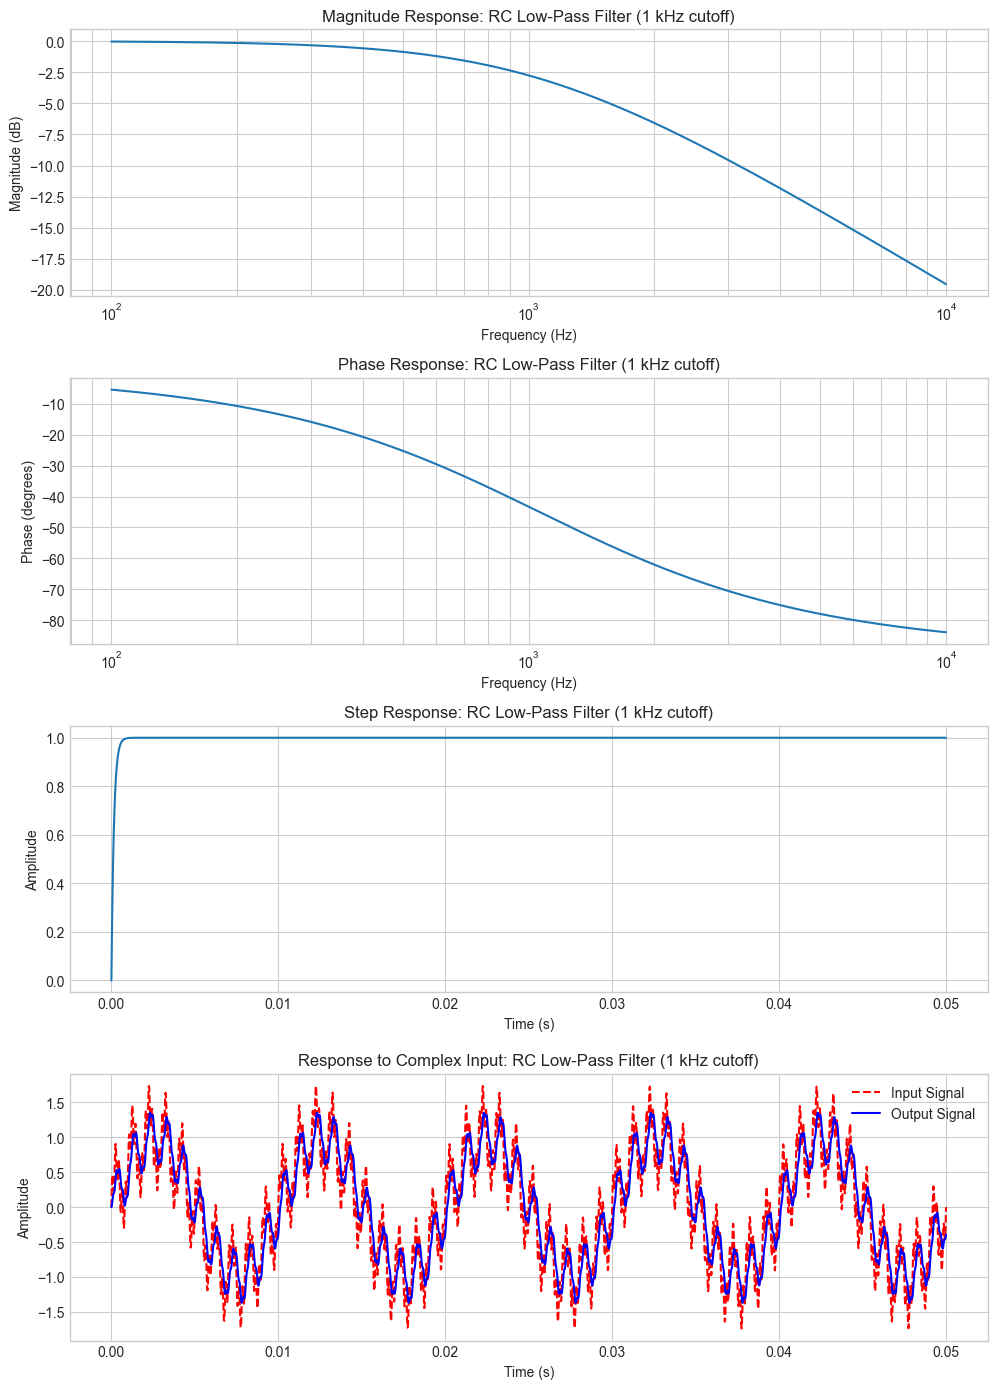

RC Low-Pass Filter:
Cutoff frequency: 1000 Hz
R = 15.0 kΩ, C = 10.0 nF
Time constant = 0.15000000000000002 ms


In [2]:
analyze_low_pass_filter()

## Exercise 2: Audio Bass Boost (Low-Shelf Filter)

**Problem:**  
Design an active **low-shelf filter** that provides a **+6 dB bass boost** below **200 Hz**.

---

**Solution:**

1. A **+6 dB boost** corresponds to a voltage gain of:

   $$
   G_0 = 10^{6/20} \approx 2.0
   $$

2. Based on Julius O. Smith’s canonical form, a **low-shelf filter** can be written as:

   $$
   H_{\text{LS}}(s) = 1 + \frac{B_0 \cdot \omega_1}{s + \omega_1}
   $$

   Where:
   - $B_0 = G_0 - 1 = 2 - 1 = 1$
   - $\omega_1$ is the **pole frequency** (transition frequency in radians/sec)

3. Set the desired transition frequency:
   $$
   f_c = 200 \, \text{Hz} \quad \Rightarrow \quad \omega_1 = 2\pi f_c = 1256.6 \, \text{rad/s}
   $$

4. Plug into the formula:

   $$
   H_{\text{LS}}(s) = 1 + \frac{1 \cdot 1256.6}{s + 1256.6}
   = \frac{s + 1256.6 \cdot (1 + 1)}{s + 1256.6}
   = \frac{s + 2513.2}{s + 1256.6}
   $$

   This gives:
   - A **zero** at $\omega_z = 2513.2$
   - A **pole** at $\omega_1 = 1256.6$
   - DC gain: $H(0) = 1 + 1 = 2$ (≈ +6 dB)
   - HF gain: $H(\infty) = 1$ (0 dB)

---

**Implementation:**

To realize this transfer function with an op-amp active filter:

- Choose $R_1 = 10 \, \text{k}\Omega$  
- Set the pole location using the capacitor:

  $$
  C = \frac{1}{R_1 \cdot \omega_1} = \frac{1}{10^4 \cdot 1256.6} \approx 79.6 \, \text{nF} \quad \text{(use standard } 82 \, \text{nF)}
  $$

- For a gain of $G_0 = 2$, set the non-inverting gain stage:

  $$
  A_v = 1 + \frac{R_f}{R_{\text{in}}} = 2 \quad \Rightarrow \quad R_f = R_{\text{in}} = 10 \, \text{k}\Omega
  $$

---

**Result:**  
This filter boosts the amplitude of low frequencies (bass) by approximately **+6 dB below 200 Hz**, while leaving high frequencies unchanged. It is a canonical **first-order low-shelf filter**, widely used in audio equalizers, mixing consoles, and tone control circuits.


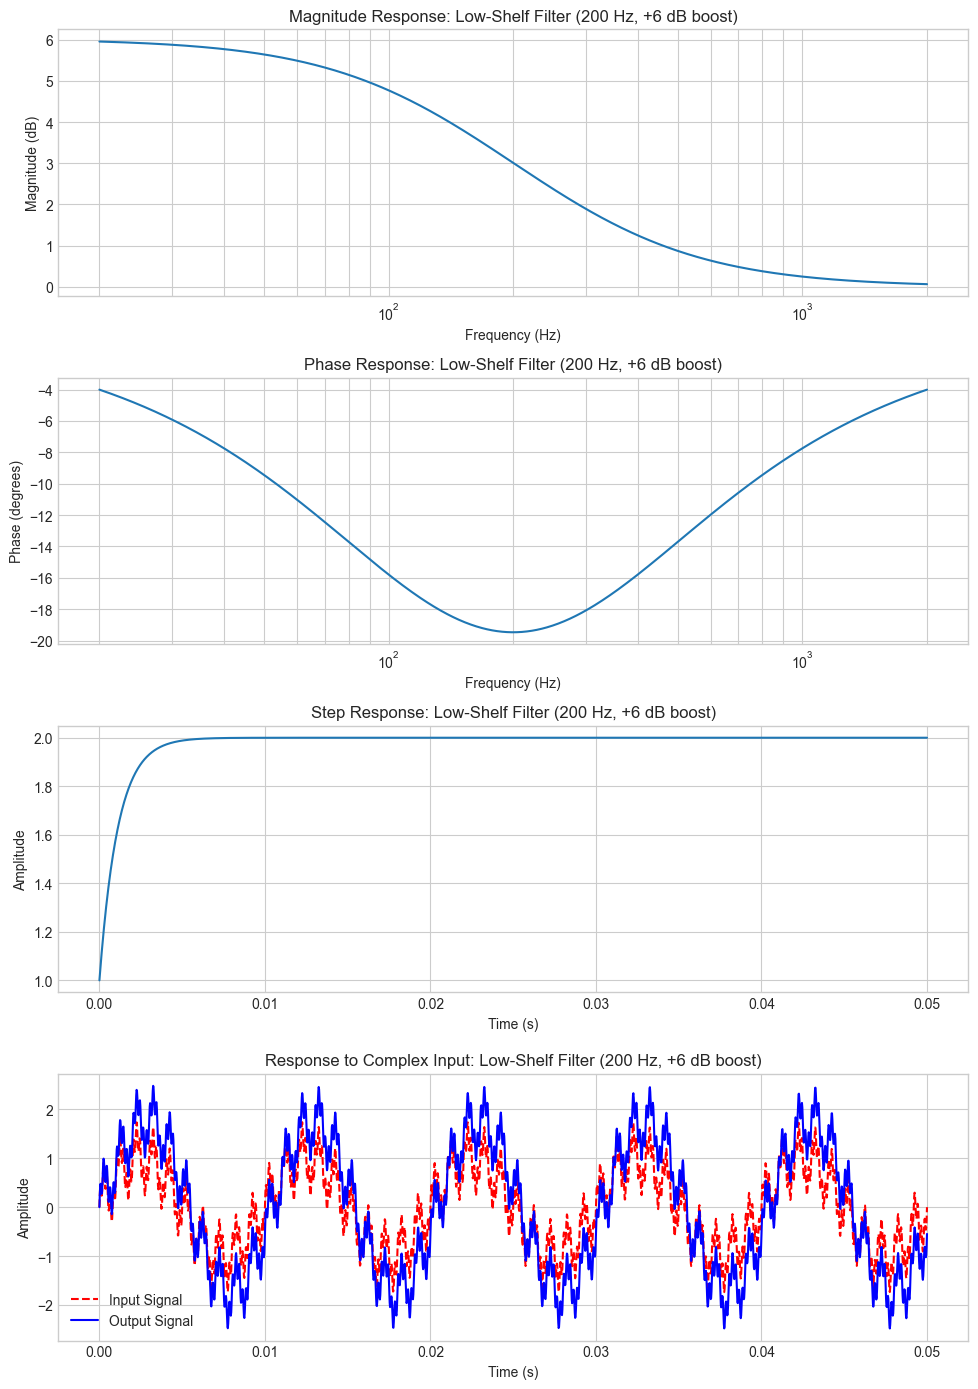

Low-Shelf Filter:
Transition frequency: 200 Hz
Low-frequency gain: +6.0 dB
High-frequency gain: +0.0 dB


In [3]:
#analyze_low_pass_filter()
analyze_low_shelf_filter()
#analyze_high_shelf_filter()
#analyze_envelope_follower()
#analyze_anti_aliasing_filter()
#analyze_dc_blocking_filter()
#analyze_auto_wah()


## Exercise 4: Envelope Follower for Audio Effects

**Problem:** Design an envelope follower circuit for a guitar effects pedal that tracks the amplitude of the input signal.

**Solution:**
1. An envelope follower consists of:
   - A rectifier (to convert AC to DC)
   - A low-pass filter (to smooth the rectified signal)
2. For the low-pass filter portion:
   - We want a time constant that responds quickly to attacks but decays smoothly
   - Attack time constant: τₐ = 10 ms (RC = 0.01)
   - Decay time constant: τd = 100 ms (RC = 0.1)
3. Implementation:
   - Rectifier using diodes and op-amp
   - For attack: R₁ = 10 kΩ, C = 1 μF
   - For decay: R₂ = 100 kΩ, same C
   - Use a non-inverting buffer to prevent loading effects

## Envelope Follower: Transfer Function After Rectification

We consider the envelope follower circuit **after the full-wave rectifier**. The rectifier outputs a unipolar signal $|x(t)|$, which is then passed through a smoothing filter.

### Circuit Description

The smoothing stage consists of:

* A resistor $R$
* A capacitor $C$

The values of $R$ change dynamically:

* For **attack** (when the input increases), a smaller resistor $R_a$ is used
* For **decay** (when the input decreases), a larger resistor $R_d$ is used

This creates a **nonlinear RC filter** whose time constant depends on the direction of the input change.

### Time Constants

* Attack time constant: $\tau_a = R_a C$
* Decay time constant: $\tau_d = R_d C$

These define two first-order systems, but only one is active at a time, depending on the sign of $\frac{d}{dt}|x(t)|$.

### Transfer Functions

We model the envelope filter as a linear system in each region:

* **Attack phase**: when $\frac{d|x(t)|}{dt} > 0$

$$
H_a(s) = \frac{1}{\tau_a s + 1} = \frac{1}{R_a C s + 1}
$$

* **Decay phase**: when $\frac{d|x(t)|}{dt} < 0$

$$
H_d(s) = \frac{1}{\tau_d s + 1} = \frac{1}{R_d C s + 1}
$$

### Example Values

Using:

* $R_a = 10\ \text{k}\Omega$, $R_d = 100\ \text{k}\Omega$
* $C = 1\ \mu\text{F}$

Then:

* $\tau_a = 0.01\ \text{s}$, so $H_a(s) = \frac{1}{0.01 s + 1}$
* $\tau_d = 0.1\ \text{s}$, so $H_d(s) = \frac{1}{0.1 s + 1}$

### Summary

The envelope follower acts as a piecewise linear system with:

$$
H(s) =
\begin{cases}
\frac{1}{\tau_a s + 1}, & \text{if } \frac{d|x(t)|}{dt} > 0 \quad \text{(attack)} \\
\frac{1}{\tau_d s + 1}, & \text{if } \frac{d|x(t)|}{dt} < 0 \quad \text{(decay)}
\end{cases}
$$

This is not a single LTI system but a hybrid model with two different transfer functions, switching based on the derivative of the input.

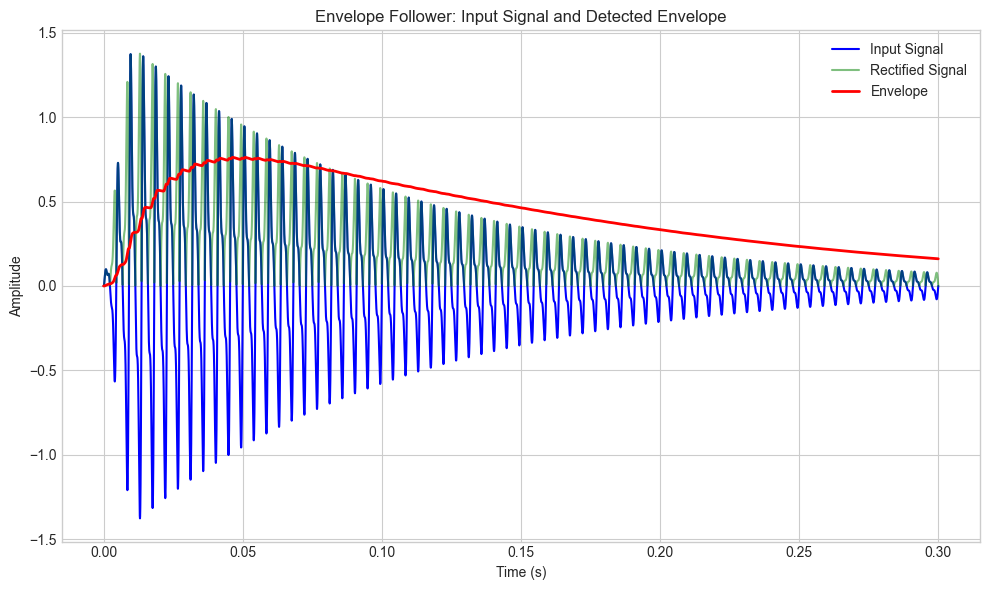

Envelope Follower:
Attack time constant: 10.0 ms
Decay time constant: 100.0 ms
Process: 1) Rectification (abs value) 2) Asymmetric smoothing


In [4]:
#analyze_low_pass_filter()
#analyze_low_shelf_filter()
#analyze_high_shelf_filter()
analyze_envelope_follower()
#analyze_anti_aliasing_filter()
#analyze_dc_blocking_filter()
#analyze_auto_wah()

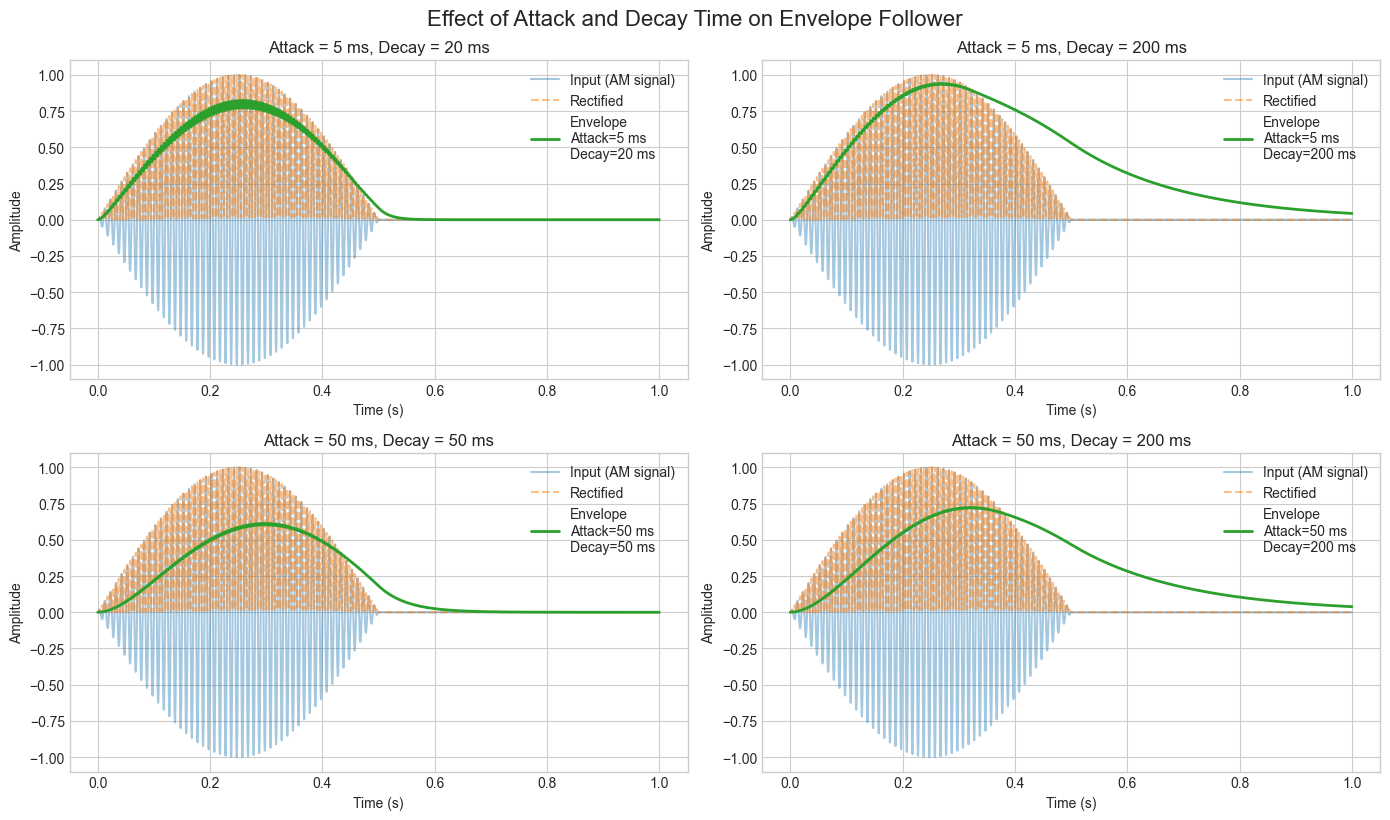

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling settings
fs = 10000  # Hz
t = np.linspace(0, 1, fs)

# Simulated amplitude-modulated input signal
modulator = np.maximum(0, np.sin(2 * np.pi * 1 * t))  # 1 Hz envelope
carrier = np.sin(2 * np.pi * 100 * t)
input_signal = modulator * carrier
rectified = np.abs(input_signal)

# Function to compute envelope with given attack and decay times
def compute_envelope(rectified, attack_tc, decay_tc):
    alpha_a = 1 - np.exp(-1 / (fs * attack_tc))
    alpha_d = 1 - np.exp(-1 / (fs * decay_tc))
    env = np.zeros_like(rectified)
    for i in range(1, len(rectified)):
        if rectified[i] > env[i - 1]:
            env[i] = alpha_a * rectified[i] + (1 - alpha_a) * env[i - 1]
        else:
            env[i] = alpha_d * rectified[i] + (1 - alpha_d) * env[i - 1]
    return env

# Different attack/decay settings to compare
settings = [
    (0.005, 0.02),  # fast attack, fast decay
    (0.005, 0.2),   # fast attack, slow decay
    (0.05, 0.05),   # slow attack, slow decay
    (0.05, 0.2),    # slow attack, slower decay
]

# Plot
plt.figure(figsize=(14, 8))
for i, (attack, decay) in enumerate(settings, 1):
    env = compute_envelope(rectified, attack, decay)
    plt.subplot(2, 2, i)
    plt.plot(t, input_signal, alpha=0.4, label="Input (AM signal)")
    plt.plot(t, rectified, '--', alpha=0.5, label="Rectified")
    plt.plot(t, env, label=f"Envelope\nAttack={attack*1000:.0f} ms\nDecay={decay*1000:.0f} ms", linewidth=2)
    plt.title(f"Attack = {attack*1000:.0f} ms, Decay = {decay*1000:.0f} ms")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend(loc="upper right")

plt.tight_layout()
plt.suptitle("Effect of Attack and Decay Time on Envelope Follower", fontsize=16, y=1.02)
plt.show()




## Exercise 5: Anti-Aliasing Filter for ADC

**Problem:** Design an active low-pass filter to prevent aliasing when sampling audio at 48 kHz with a 12-bit ADC.

**Solution:**
1. Nyquist frequency = 48 kHz / 2 = 24 kHz
2. We need to attenuate frequencies above 24 kHz
3. For good anti-aliasing, cutoff frequency should be lower: $f_c = 20$ kHz
4. For a first-order LPF: $H(s) = \frac{1}{RC s + 1}$
5. Implementation using an op-amp:
   - $\omega_c = 2\pi \times 20000 = 125664$ rad/s
   - RC = 1/125664 ≈ 8 μs
   - Choose C = 1 nF, R = 8 kΩ
6. Note: For better anti-aliasing, a higher-order filter would be preferable

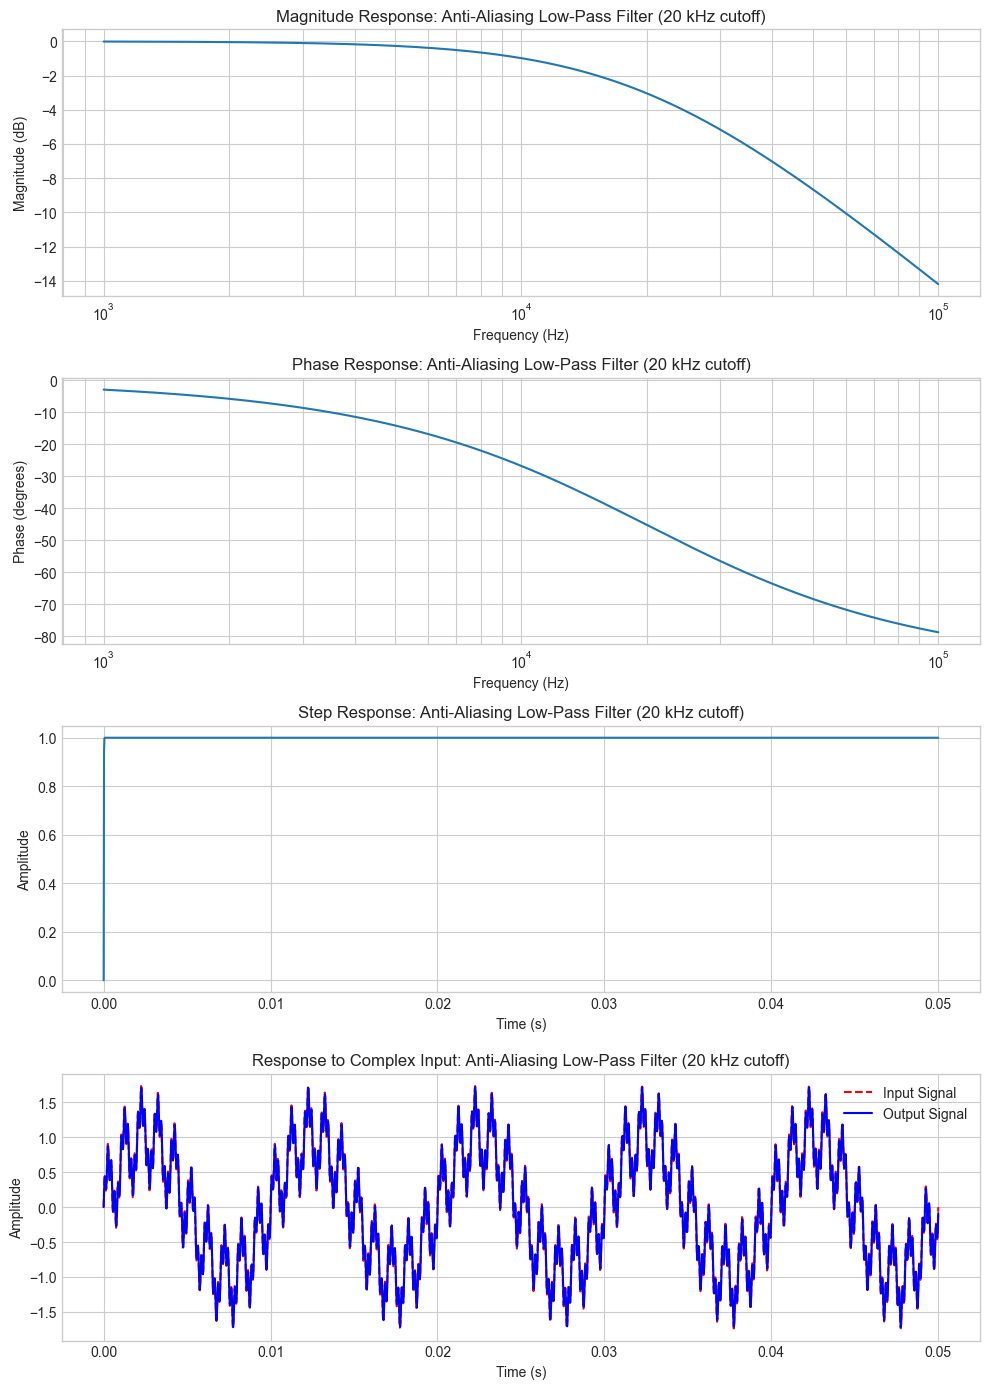

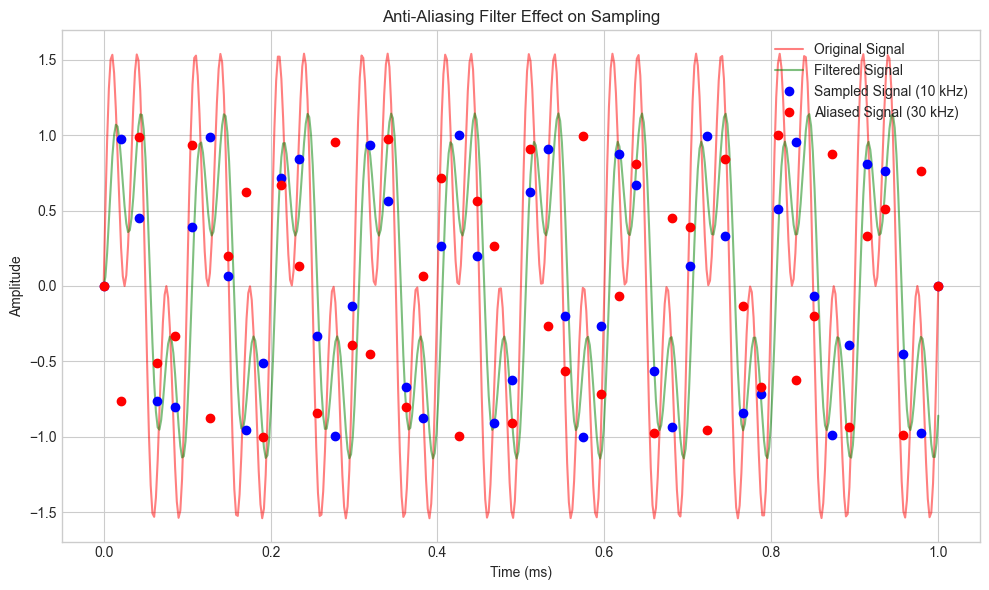

Anti-Aliasing Filter:
Cutoff frequency: 20000 Hz
R = 8.0 kΩ, C = 1.0 nF
Nyquist frequency (48 kHz sampling): 24000.0 Hz


In [6]:
#analyze_low_pass_filter()
#analyze_low_shelf_filter()
#analyze_high_shelf_filter()
#analyze_envelope_follower()
analyze_anti_aliasing_filter()
#analyze_dc_blocking_filter()
#analyze_auto_wah()

## Exercise 6: DC-Blocking Filter for Audio Input

**Problem:** Design a high-pass filter to remove DC offset from an audio signal without affecting audible frequencies.

**Solution:**
1. Audible range starts around 20 Hz, so we want $f_c$ well below this: $f_c = 5$ Hz
2. For a first-order HPF: $H(s) = \frac{s}{s + \omega_c}$
3. $\omega_c = 2\pi \times 5 = 31.4$ rad/s
4. RC = 1/31.4 ≈ 0.032 seconds
5. Implementation:
   - Choose C = 1 μF
   - R = 32 kΩ (use standard value 33 kΩ)
6. Verify: $f_c = \frac{1}{2\pi \times 33000 \times 10^{-6}} \approx 4.8$ Hz

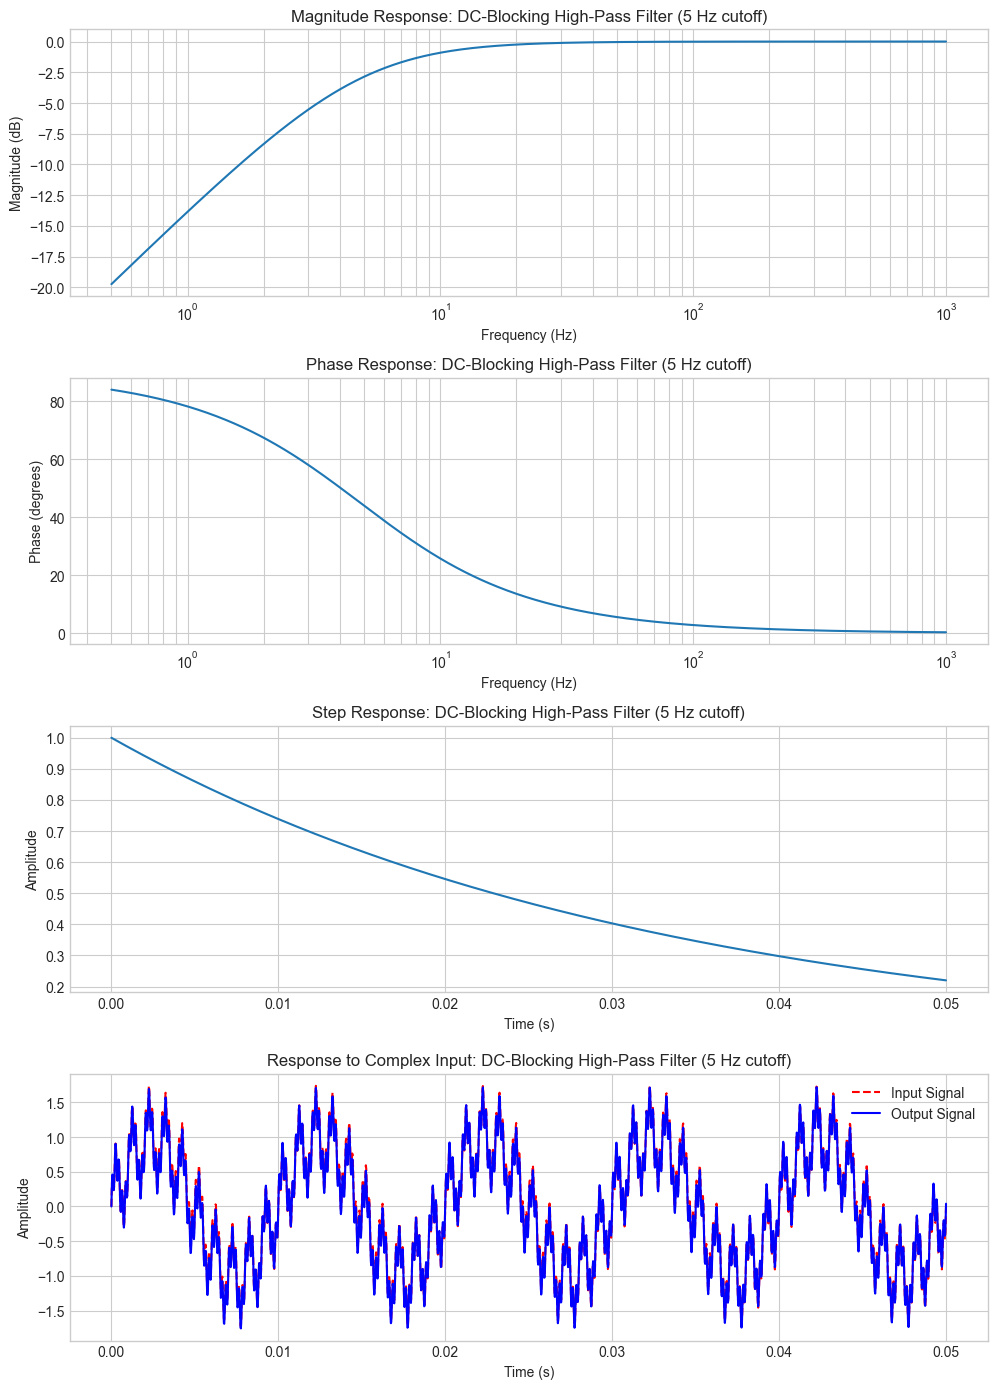

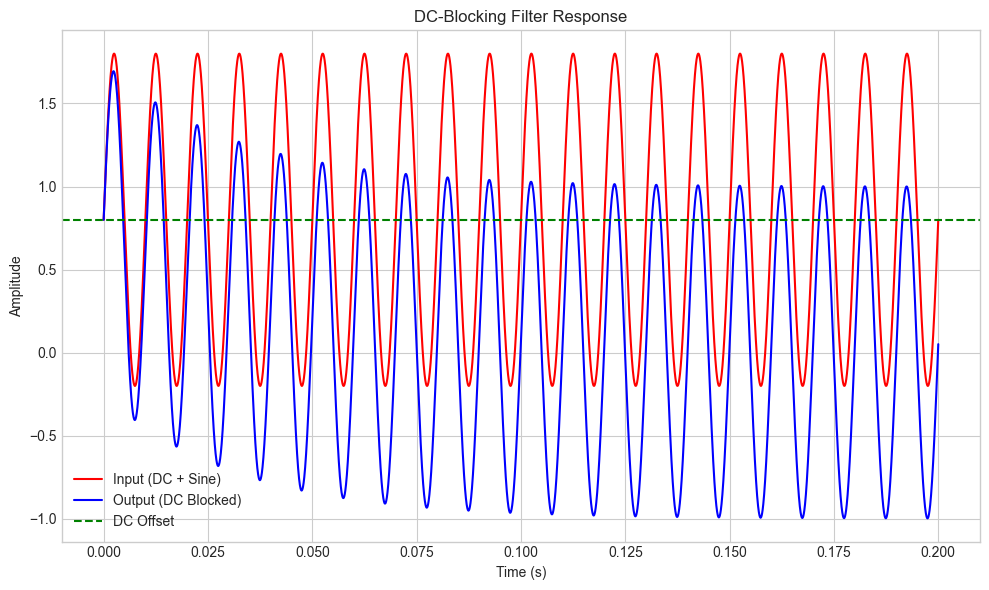

DC-Blocking Filter:
Cutoff frequency: 5 Hz
R = 33.0 kΩ, C = 1.0 μF
Time constant: 0.033 s


In [7]:
#analyze_low_pass_filter()
#analyze_low_shelf_filter()
#analyze_high_shelf_filter()
#analyze_envelope_follower()
#analyze_anti_aliasing_filter()
analyze_dc_blocking_filter()
#analyze_auto_wah()





## Challenge Exercise: Auto-Wah Effect (Envelope-Controlled Filter)

**Problem:** Design an auto-wah effect that automatically controls a bandpass filter based on the input signal's amplitude.

**Solution:**
1. Components needed:
   - Envelope follower (from Exercise 4)
   - Voltage-controlled filter
2. Envelope follower design:
   - Full-wave rectifier + LPF with $f_c = 5$ Hz
   - RC = 0.032 seconds (R = 33 kΩ, C = 1 μF)
3. Bandpass filter:
   - Created by cascading HPF and LPF
   - HPF cutoff varies from 300 Hz to 2 kHz based on control voltage
   - LPF fixed at 3 kHz
4. Implementation:
   - Use OTA (Operational Transconductance Amplifier) for voltage control
   - Control voltage from envelope follower scales OTA bias current
   - Higher input amplitude → higher control voltage → higher filter cutoff

/Users/seman/aulas_2025_1/.venv/lib/python3.13/site-packages/matplotlib/axes/_axes.py:8280: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


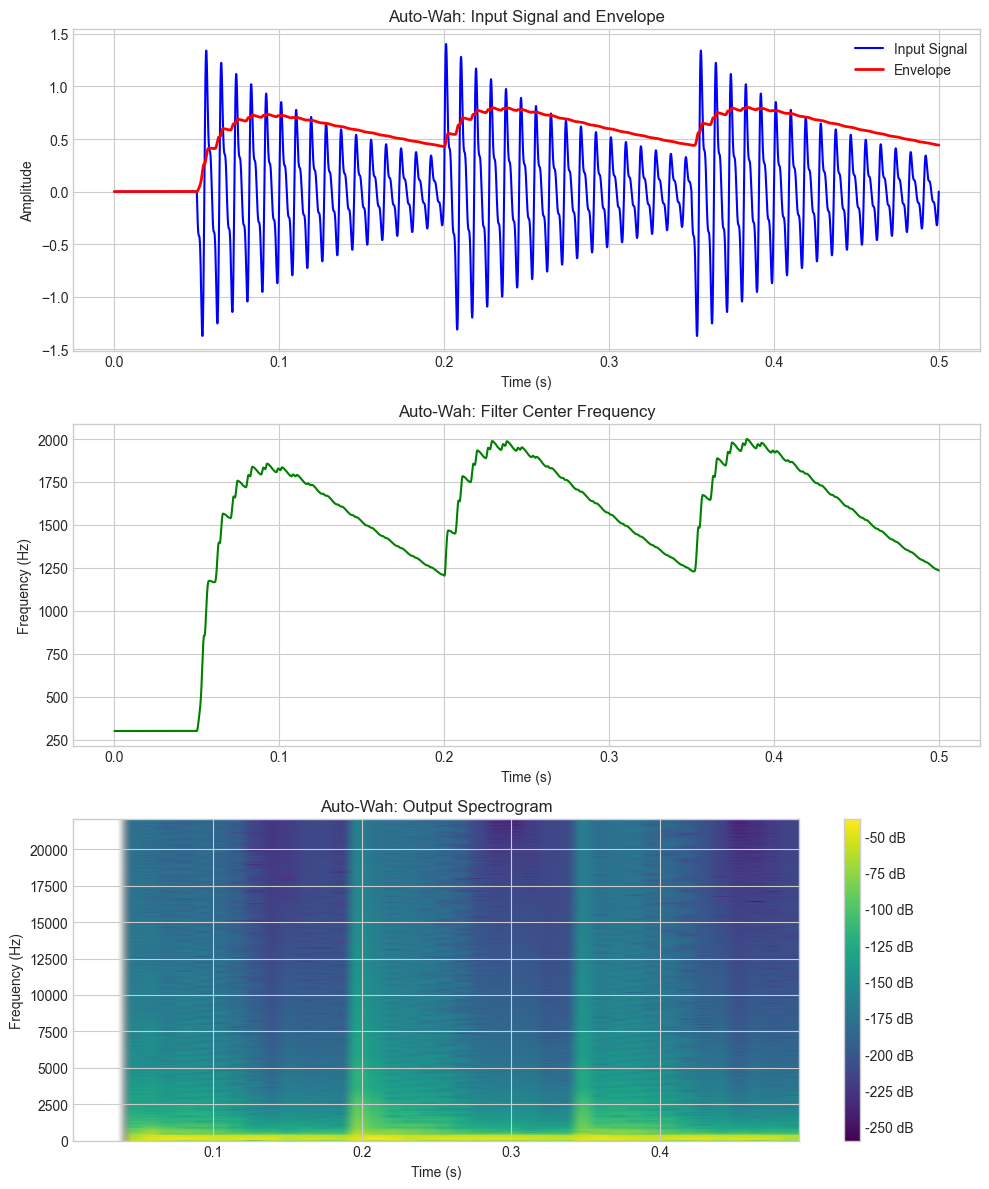

Auto-Wah Effect:
Envelope follower attack time: 10.0 ms
Envelope follower decay time: 100.0 ms
Filter frequency range: 300-2000 Hz
Components: 1) Envelope follower 2) Frequency mapping 3) Bandpass filter


In [8]:
#analyze_low_pass_filter()
#analyze_low_shelf_filter()
#analyze_high_shelf_filter()
#analyze_envelope_follower()
#analyze_anti_aliasing_filter()
#analyze_dc_blocking_filter()
analyze_auto_wah()